In [1]:
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

In [2]:
matplotlib.style.use("seaborn")

In [3]:
# Dataset name.
DATASET_TARGET = "real-world/Dribbble"
PATH_TO_DATA = f"../results/3-channels/{DATASET_TARGET}"

SEEDS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Metrics

In [4]:
dfs = []
for SEED in SEEDS:
    dfs.append(pd.read_csv(f"{PATH_TO_DATA}/results_test/{SEED}.csv", index_col = 0))
    
df = pd.concat(dfs, axis = 0)
df.head()

,test_acc,test_f1,test_auroc
1,0.688312,0.688312,0.853845
2,0.662338,0.662338,0.856096
3,0.707792,0.707792,0.877128
4,0.649351,0.649351,0.831655
5,0.603896,0.603896,0.779746


In [5]:
best_seed = df["test_acc"].idxmax()
best_seed

3

In [6]:
out = df.agg(["mean", "std"]) * 100
out

,test_acc,test_f1,test_auroc
mean,66.103896,66.103896,83.339908
std,3.207557,3.207557,2.736101


In [7]:
file = open(f"{PATH_TO_DATA}/overall.txt", "w")
file.write(out.to_string())
file.close()

# Confusion matrix

In [8]:
SEED = best_seed

In [9]:
with open(f"{PATH_TO_DATA}/confusion_matrices_test/{SEED}.pkl", "rb") as f:
    cf_matrix = pickle.load(f)   

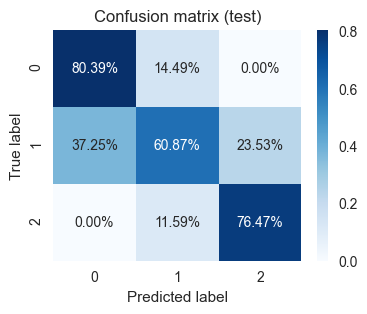

In [10]:
fig, axs = plt.subplots(figsize = (4, 3), ncols = 1, nrows = 1)
sns.heatmap(cf_matrix / cf_matrix.astype(np.float32).sum(axis = 1), annot = True, fmt = ".2%", cmap = "Blues", ax = axs)
axs.set_title("Confusion matrix (test)")
axs.set_ylabel("True label")
axs.set_xlabel("Predicted label");

# Attention coefficients

In [11]:
dfs = {}
for SEED in SEEDS:
    dfs[SEED] = pd.read_csv(f"{PATH_TO_DATA}/channels_attention_coefficients/{SEED}.csv", index_col = 0)
    
df_att_channels = pd.concat(dfs, axis = 1)
df_att_channels.columns.names = ["Seed", "Channels"]
df_att_channels.head()

Seed            1                                    2                        \
Channels  topology centrality  position label  topology centrality  position   
0         0.370451   0.486610  0.142939     2  0.443919   0.286805  0.269276   
1         0.396841   0.438483  0.164676     2  0.300446   0.481448  0.218106   
2         0.080975   0.883193  0.035832     0  0.088259   0.874897  0.036845   
3         0.561726   0.388883  0.049392     0  0.156008   0.818667  0.025325   
4         0.128124   0.815542  0.056334     1  0.161016   0.812683  0.026301   

Seed                  3              ...        8               9              \
Channels label  topology centrality  ...  position label  topology centrality   
0            2  0.432539   0.553405  ...  0.002800     2  0.739038   0.260959   
1            2  0.487544   0.496975  ...  0.000666     2  0.778787   0.221210   
2            0  0.662238   0.313089  ...  0.002336     0  0.521872   0.478126   
3            0  0.340085   0.633552  ...  0.003085     0  0.499999   0.499999   
4            1  0.530538   0.443737  ...  0.000947     1  0.526933   0.473065   

Seed                            10                             
Channels  position label  topology centrality  position label  
0         0.000004     2  0.719325   0.280530  0.000146     2  
1         0.000004     2  0.942731   0.057081  0.000188     2  
2         0.000002     0  0.941950   0.057531  0.000519     0  
3         0.000002     0  0.607693   0.388021  0.004286     0  
4         0.000002     1  0.982851   0.016753  0.000396     1  

[5 rows x 40 columns]

## Best seed

In [12]:
df_att_channels_best = df_att_channels[best_seed]
df_att_channels_best.head()

Channels,topology,centrality,position,label
0,0.432539,0.553405,0.014056,2
1,0.487544,0.496975,0.015481,2
2,0.662238,0.313089,0.024672,0
3,0.340085,0.633552,0.026363,0
4,0.530538,0.443737,0.025725,1


Text(0.5, 25.722222222222214, 'Channels')

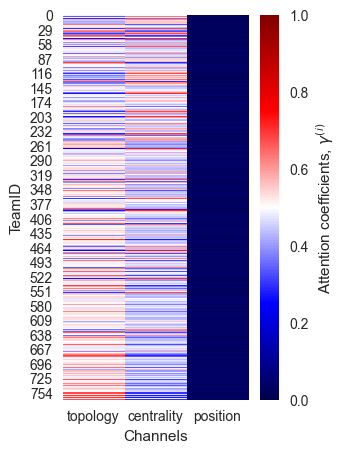

In [13]:
fig, axs = plt.subplots(figsize = (3, 5), ncols = 1, nrows = 1)
sns.heatmap(df_att_channels_best[["topology", "centrality", "position"]], vmin = 0, vmax = 1, cmap = "seismic", cbar_kws = {"label": "Attention coefficients, $\gamma^{(i)}$"}, 
            ax = axs)
axs.set_ylabel("TeamID")
axs.set_xlabel("Channels")

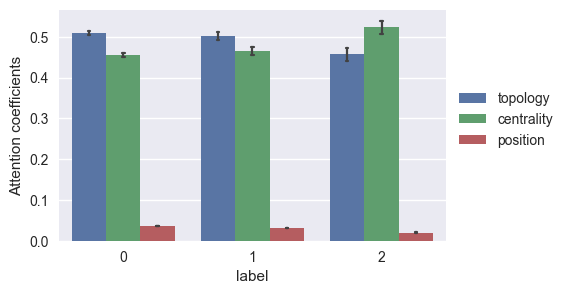

In [14]:
# Get attention coefficients at team level for each channel.
fig, axs = plt.subplots(figsize = (5, 3), ncols = 1, nrows = 1)

m = pd.melt(df_att_channels_best, id_vars = ["label"], value_vars = ["topology", "centrality", "position"], 
            var_name = "channels", value_name = "Attention coefficients")
sns.barplot(x = "label", hue = "channels", y = "Attention coefficients", data = m, capsize = .02, 
            estimator = np.mean, errwidth = 1.6, ci = 95)
axs.legend(loc = "best", bbox_to_anchor = (1, 0.7))

## Average

In [15]:
df_att_channels_mean = df_att_channels.groupby(axis = 1, level = "Channels").mean()
df_att_channels_mean.head()

Channels,centrality,label,position,topology
0,0.572887,2.0,0.045018,0.382095
1,0.432459,2.0,0.042876,0.524664
2,0.445272,0.0,0.018264,0.536464
3,0.660180,0.0,0.028706,0.311114
4,0.469821,1.0,0.020747,0.509432


Text(0.5, 25.722222222222214, 'Channels')

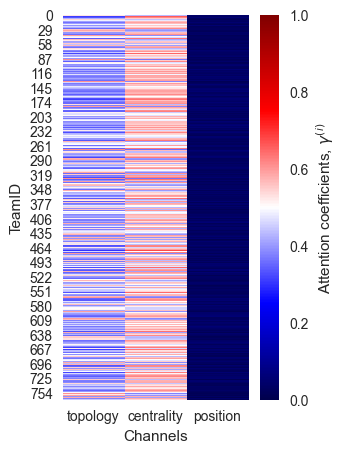

In [16]:
fig, axs = plt.subplots(figsize = (3, 5), ncols = 1, nrows = 1)
sns.heatmap(df_att_channels_mean[["topology", "centrality", "position"]], vmin = 0, vmax = 1, cmap = "seismic", cbar_kws = {"label": "Attention coefficients, $\gamma^{(i)}$"}, 
            ax = axs)
axs.set_ylabel("TeamID")
axs.set_xlabel("Channels")

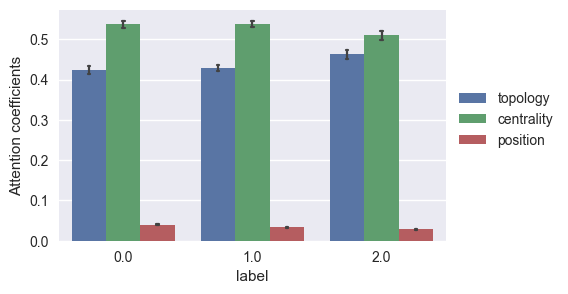

In [17]:
# Get attention coefficients at team level for each channel.
fig, axs = plt.subplots(figsize = (5, 3), ncols = 1, nrows = 1)

m = pd.melt(df_att_channels_mean, id_vars = ["label"], value_vars = ["topology", "centrality", "position"], 
            var_name = "channels", value_name = "Attention coefficients")
sns.barplot(x = "label", hue = "channels", y = "Attention coefficients", data = m, capsize = .02, 
            estimator = np.mean, errwidth = 1.6, ci = 95)
axs.legend(loc = "best", bbox_to_anchor = (1, 0.7))